<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Graph Embeddings 101</h1>
        <h1>From word2vec to node2vec, and beyond</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tqdm as tq
from tqdm import tqdm

import networkx as nx
import scipy.io
from collections import defaultdict

import sklearn
from sklearn.cluster import KMeans

from gensim.test.utils import datapath
from gensim import utils
import gensim.models

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: ffff54226fda269bc490396618e98c7d1c61790b

json      : 2.0.9
sklearn   : 0.24.1
matplotlib: 3.3.2
gensim    : 3.8.3
scipy     : 1.6.1
tqdm      : 4.50.2
networkx  : 2.5
pandas    : 1.2.2
watermark : 2.1.0
numpy     : 1.20.1



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Word2vec

We're going to quickly train a word2vec model using the text of Alice in wonderland, following the approach in the [gensim documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html). We define a simple class that generates the sentences from our text

In [4]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = 'data/alice_in_wonderland.txt'
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

And instanciate it:

In [5]:
sentences = MyCorpus()

we can get a few sentences easily:

In [6]:
pprint(list(sentences)[100:105])

[['rather',
  'sleepy',
  'and',
  'went',
  'on',
  'saying',
  'to',
  'herself',
  'in',
  'dreamy',
  'sort',
  'of'],
 ['way',
  'do',
  'cats',
  'eat',
  'bats',
  'do',
  'cats',
  'eat',
  'bats',
  'and',
  'sometimes',
  'do'],
 ['bats',
  'eat',
  'cats',
  'for',
  'you',
  'see',
  'as',
  'she',
  'couldn',
  'answer',
  'either'],
 ['question',
  'it',
  'didn',
  'much',
  'matter',
  'which',
  'way',
  'she',
  'put',
  'it',
  'she',
  'felt'],
 ['that',
  'she',
  'was',
  'dozing',
  'off',
  'and',
  'had',
  'just',
  'begun',
  'to',
  'dream',
  'that',
  'she']]


To train our model we can simply do

In [7]:
model = gensim.models.Word2Vec(sentences, size=30, window=2, min_count=1)

The wv field in the model object contains the vector encodings of each word. So if we want go get hte vector for the word "alice", we must simply do

In [8]:
model.wv['alice']

array([ 0.10764992,  0.5670966 ,  0.4548764 ,  0.19699137,  0.3509759 ,
        0.18839458, -0.17848685,  0.7186649 ,  0.30519566,  0.253352  ,
        0.19681823,  0.44755054, -0.06178085,  1.0144345 , -0.17815004,
        0.00345359, -0.38949615, -0.35044953,  0.57830346, -0.36845046,
       -0.40441778, -0.3932217 ,  0.4329478 , -0.81294507,  0.16012426,
        0.02533186,  0.21462281, -0.6769186 ,  0.67923385, -0.35723066],
      dtype=float32)

In total, we have 2560 unique words encoded as vectors of dimention 30

In [9]:
model.wv.vectors.shape

(2560, 30)

We can visualize all the word embeddings we generated

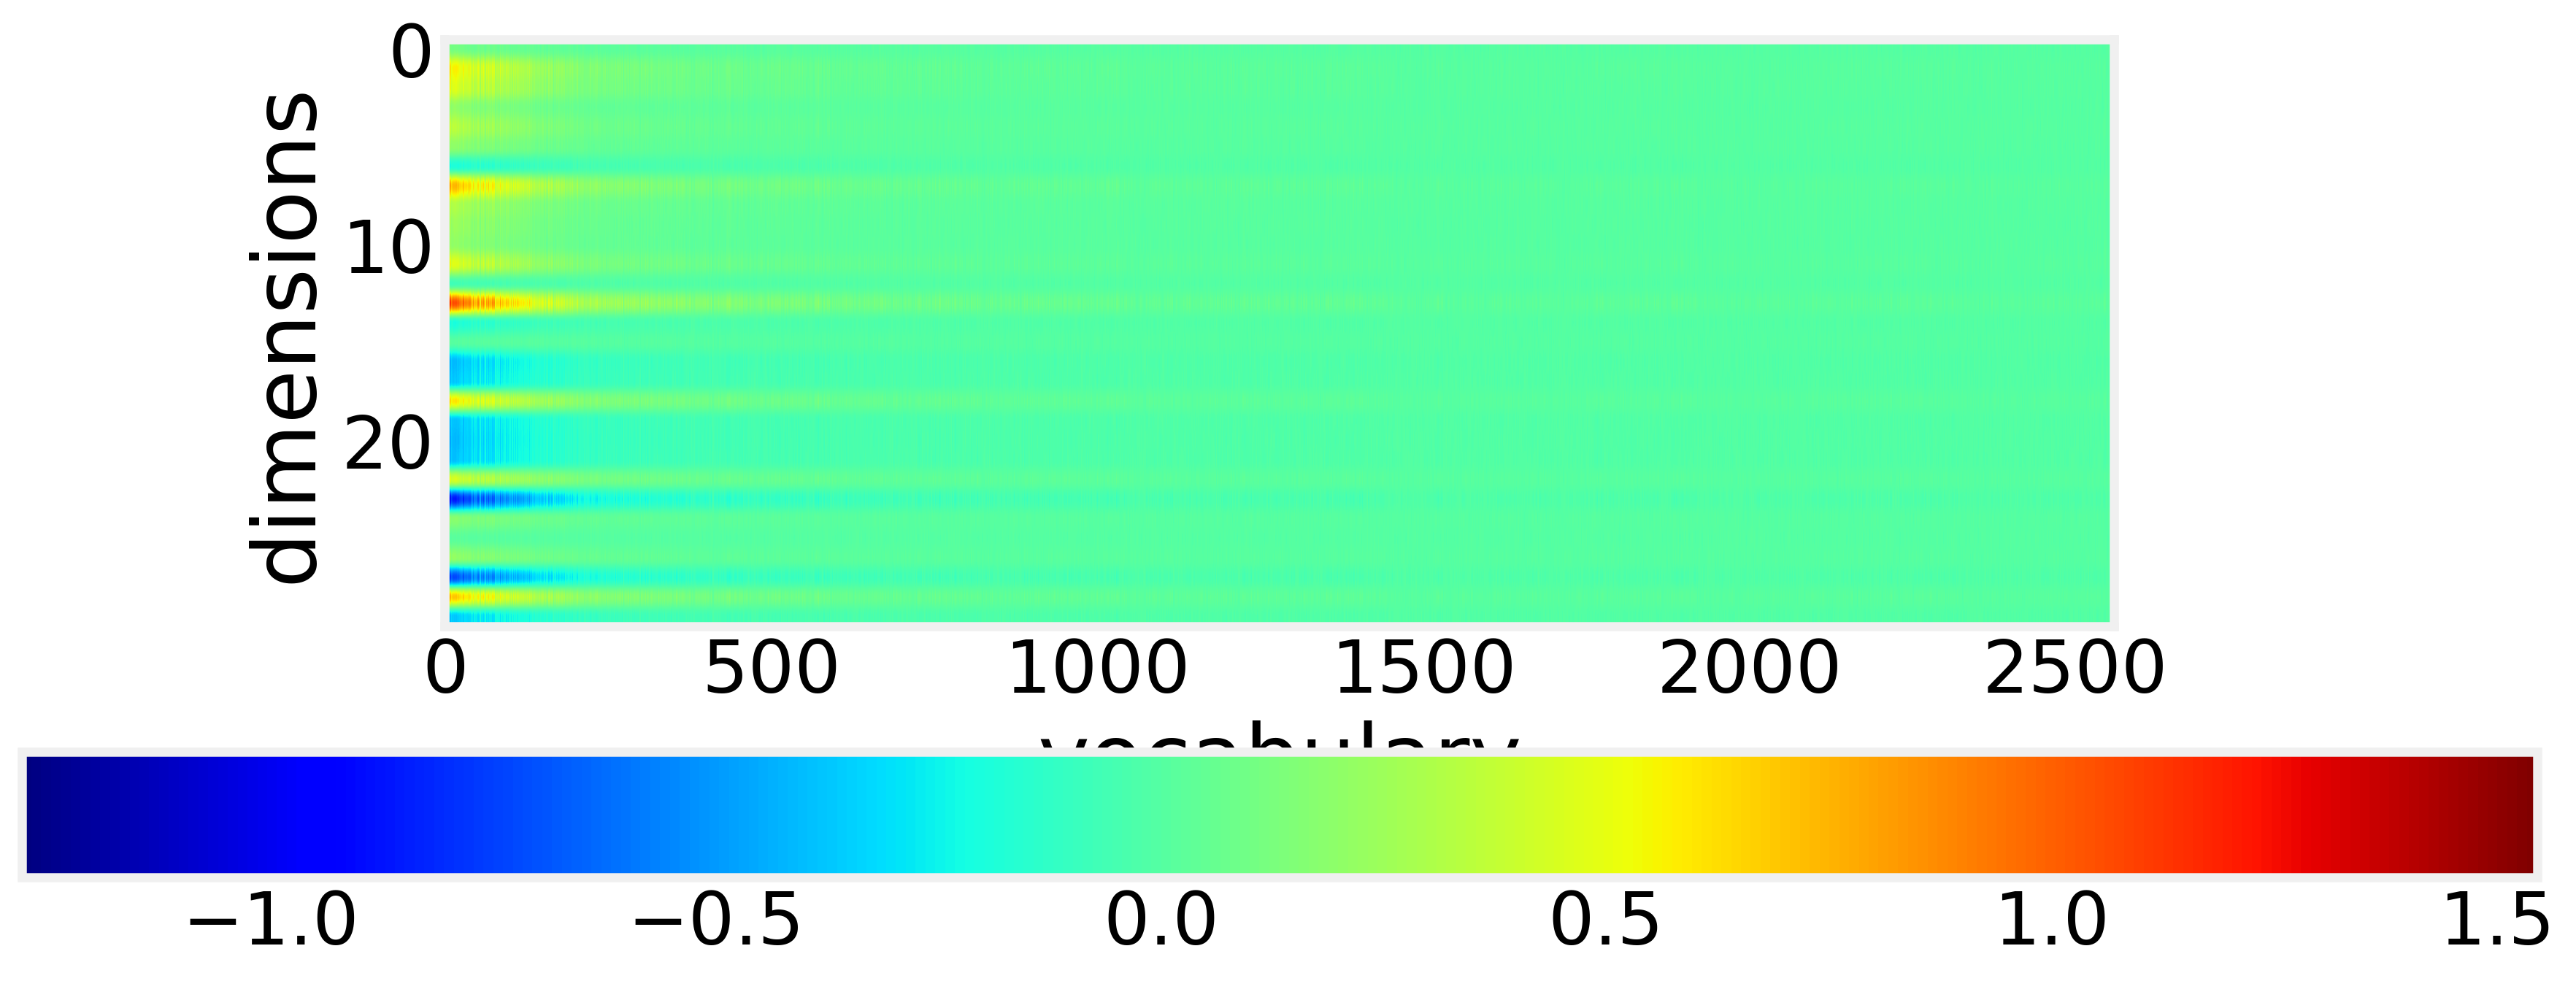

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(model.wv.vectors.T, aspect=30, cmap=cm.jet)
plt.grid(None)
plt.xlabel("vocabulary")
plt.ylabel("dimensions")
plt.colorbar(orientation='horizontal')

One interesting point to note is that the words with higher ids tend to have less differnetiated vectors. This is due to the fact that gensim orders the word ids by freqency so the most frequent words (which will have the benefit of the most context) will have lower id numbers than the least frequent ones. The Top 10 words are

In [11]:
for i in range(10):
    print(i, model.wv.index2word[i])

0 the
1 and
2 to
3 it
4 she
5 of
6 said
7 you
8 alice
9 in


which are mostly stopwords as we didn't filter them.

# Node2vec

Here we are following the code from the [original node2vec implementation](https://github.com/aditya-grover/node2vec), with just a few simplications. Similarly to what we've done in the case of word2vec above, we write a class that will be responsible for generateing the random walks in our graph

In [12]:
class MyGraph():
    def __init__(self, graph, probs, p, q, max_walks, walk_len, workers):

        self.graph = graph # Theggraph we're going to use
        self.probs = probs
        self.p = p
        self.q = q
        self.max_walks = max_walks
        self.walk_len = walk_len
        self.workers = workers 
        return
    
    def compute_probabilities(self):
        
        G = self.graph
        for source_node in G.nodes():
            for current_node in G.neighbors(source_node):
                probs_ = list()
                for destination in G.neighbors(current_node):

                    if source_node == destination:
                        prob_ = G[current_node][destination].get('weight',1) * (1/self.p)
                    elif destination in G.neighbors(source_node):
                        prob_ = G[current_node][destination].get('weight',1)
                    else:
                        prob_ = G[current_node][destination].get('weight',1) * (1/self.q)

                    probs_.append(prob_)

                self.probs[source_node]['probabilities'][current_node] = probs_/np.sum(probs_)
        
        return
    
    def generate_random_walks(self):
        G = self.graph
        walks = list()
        for start_node in G.nodes():
            for i in range(self.max_walks):
                
                walk = [start_node]
                walk_options = list(G[start_node])
                if len(walk_options)==0:
                    break
                first_step = np.random.choice(walk_options)
                walk.append(first_step)
                
                for k in range(self.walk_len-2):
                    walk_options = list(G[walk[-1]])
                    if len(walk_options)==0:
                        break
                    probabilities = self.probs[walk[-2]]['probabilities'][walk[-1]]
                    next_step = np.random.choice(walk_options, p=probabilities)
                    walk.append(next_step)
                
                walks.append(walk)
        np.random.shuffle(walks)
        walks = [list(map(str,walk)) for walk in walks]
        
        return walks

We're going to use the Karate club graph as our example graph

In [13]:
Karate=nx.karate_club_graph()

You'll likely remember it from our [previous post](http://localhost:8890/notebooks/Search.ipynb)

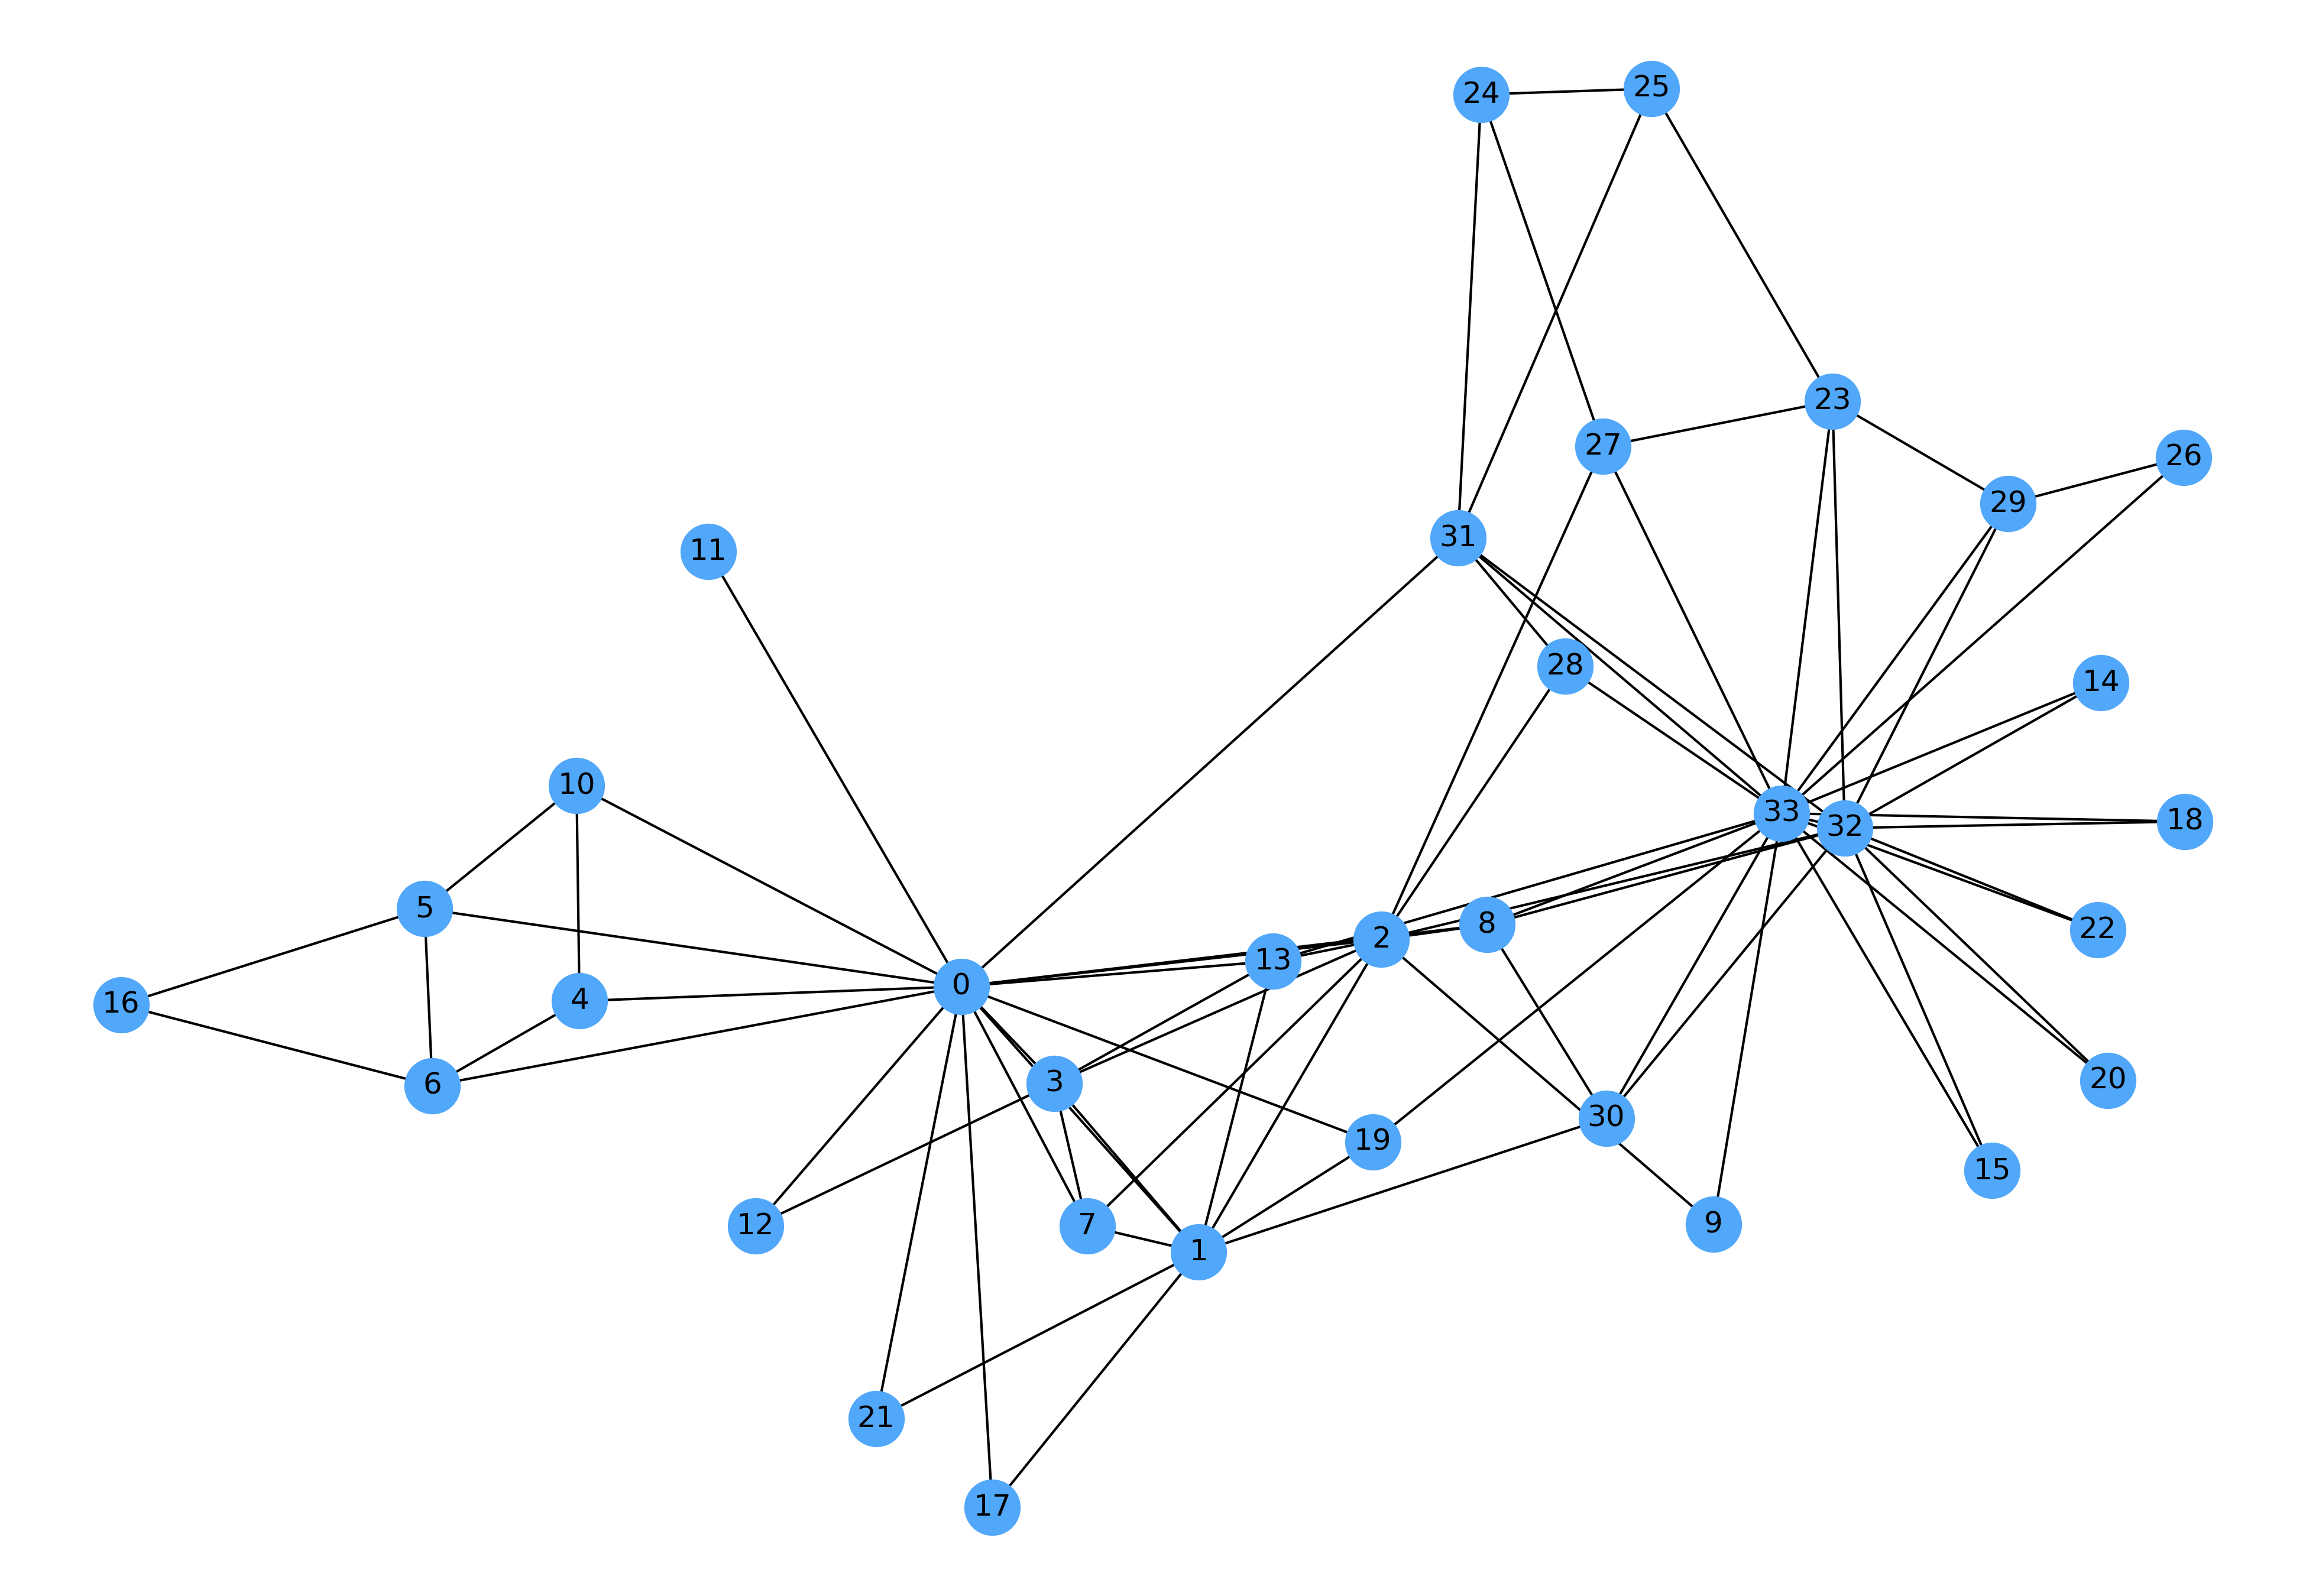

In [14]:
np.random.seed(123)
layout = nx.layout.spring_layout(Karate)
nx.draw(Karate, pos=layout, node_color=colors[0], node_size=500)
nx.draw_networkx_labels(Karate, pos=layout, font_color='k');

We initialize the data structure we will use to calculate the probabilities during the random walk

In [15]:
probs = defaultdict(dict)
for node in Karate.nodes():
    probs[node]['probabilities'] = dict()

And the class that we will use to generate the random walks

In [16]:
G = MyGraph(Karate, probs, 
            p=0.4, #
            q=1.0, #
            max_walks=20, 
            walk_len=80, 
            workers=16
           )

And finally generate all the random walks

In [17]:
G.compute_probabilities()
walks = G.generate_random_walks()

These are the equivalente of the sentences above, but now each word is a node

In [18]:
len(walks)

680

And finally, we run word2vec on our graph

In [19]:
model = gensim.models.Word2Vec(walks, 
                               size=2, # For plotting convenience
                               window=2, 
                               min_count=0, 
                               sg=1, 
                               workers=16,
                               compute_loss=True)

In [20]:
w2v_emb = model.wv

And we can easily visualize the embeddings

Text(0, 0.5, 'Dim 2')

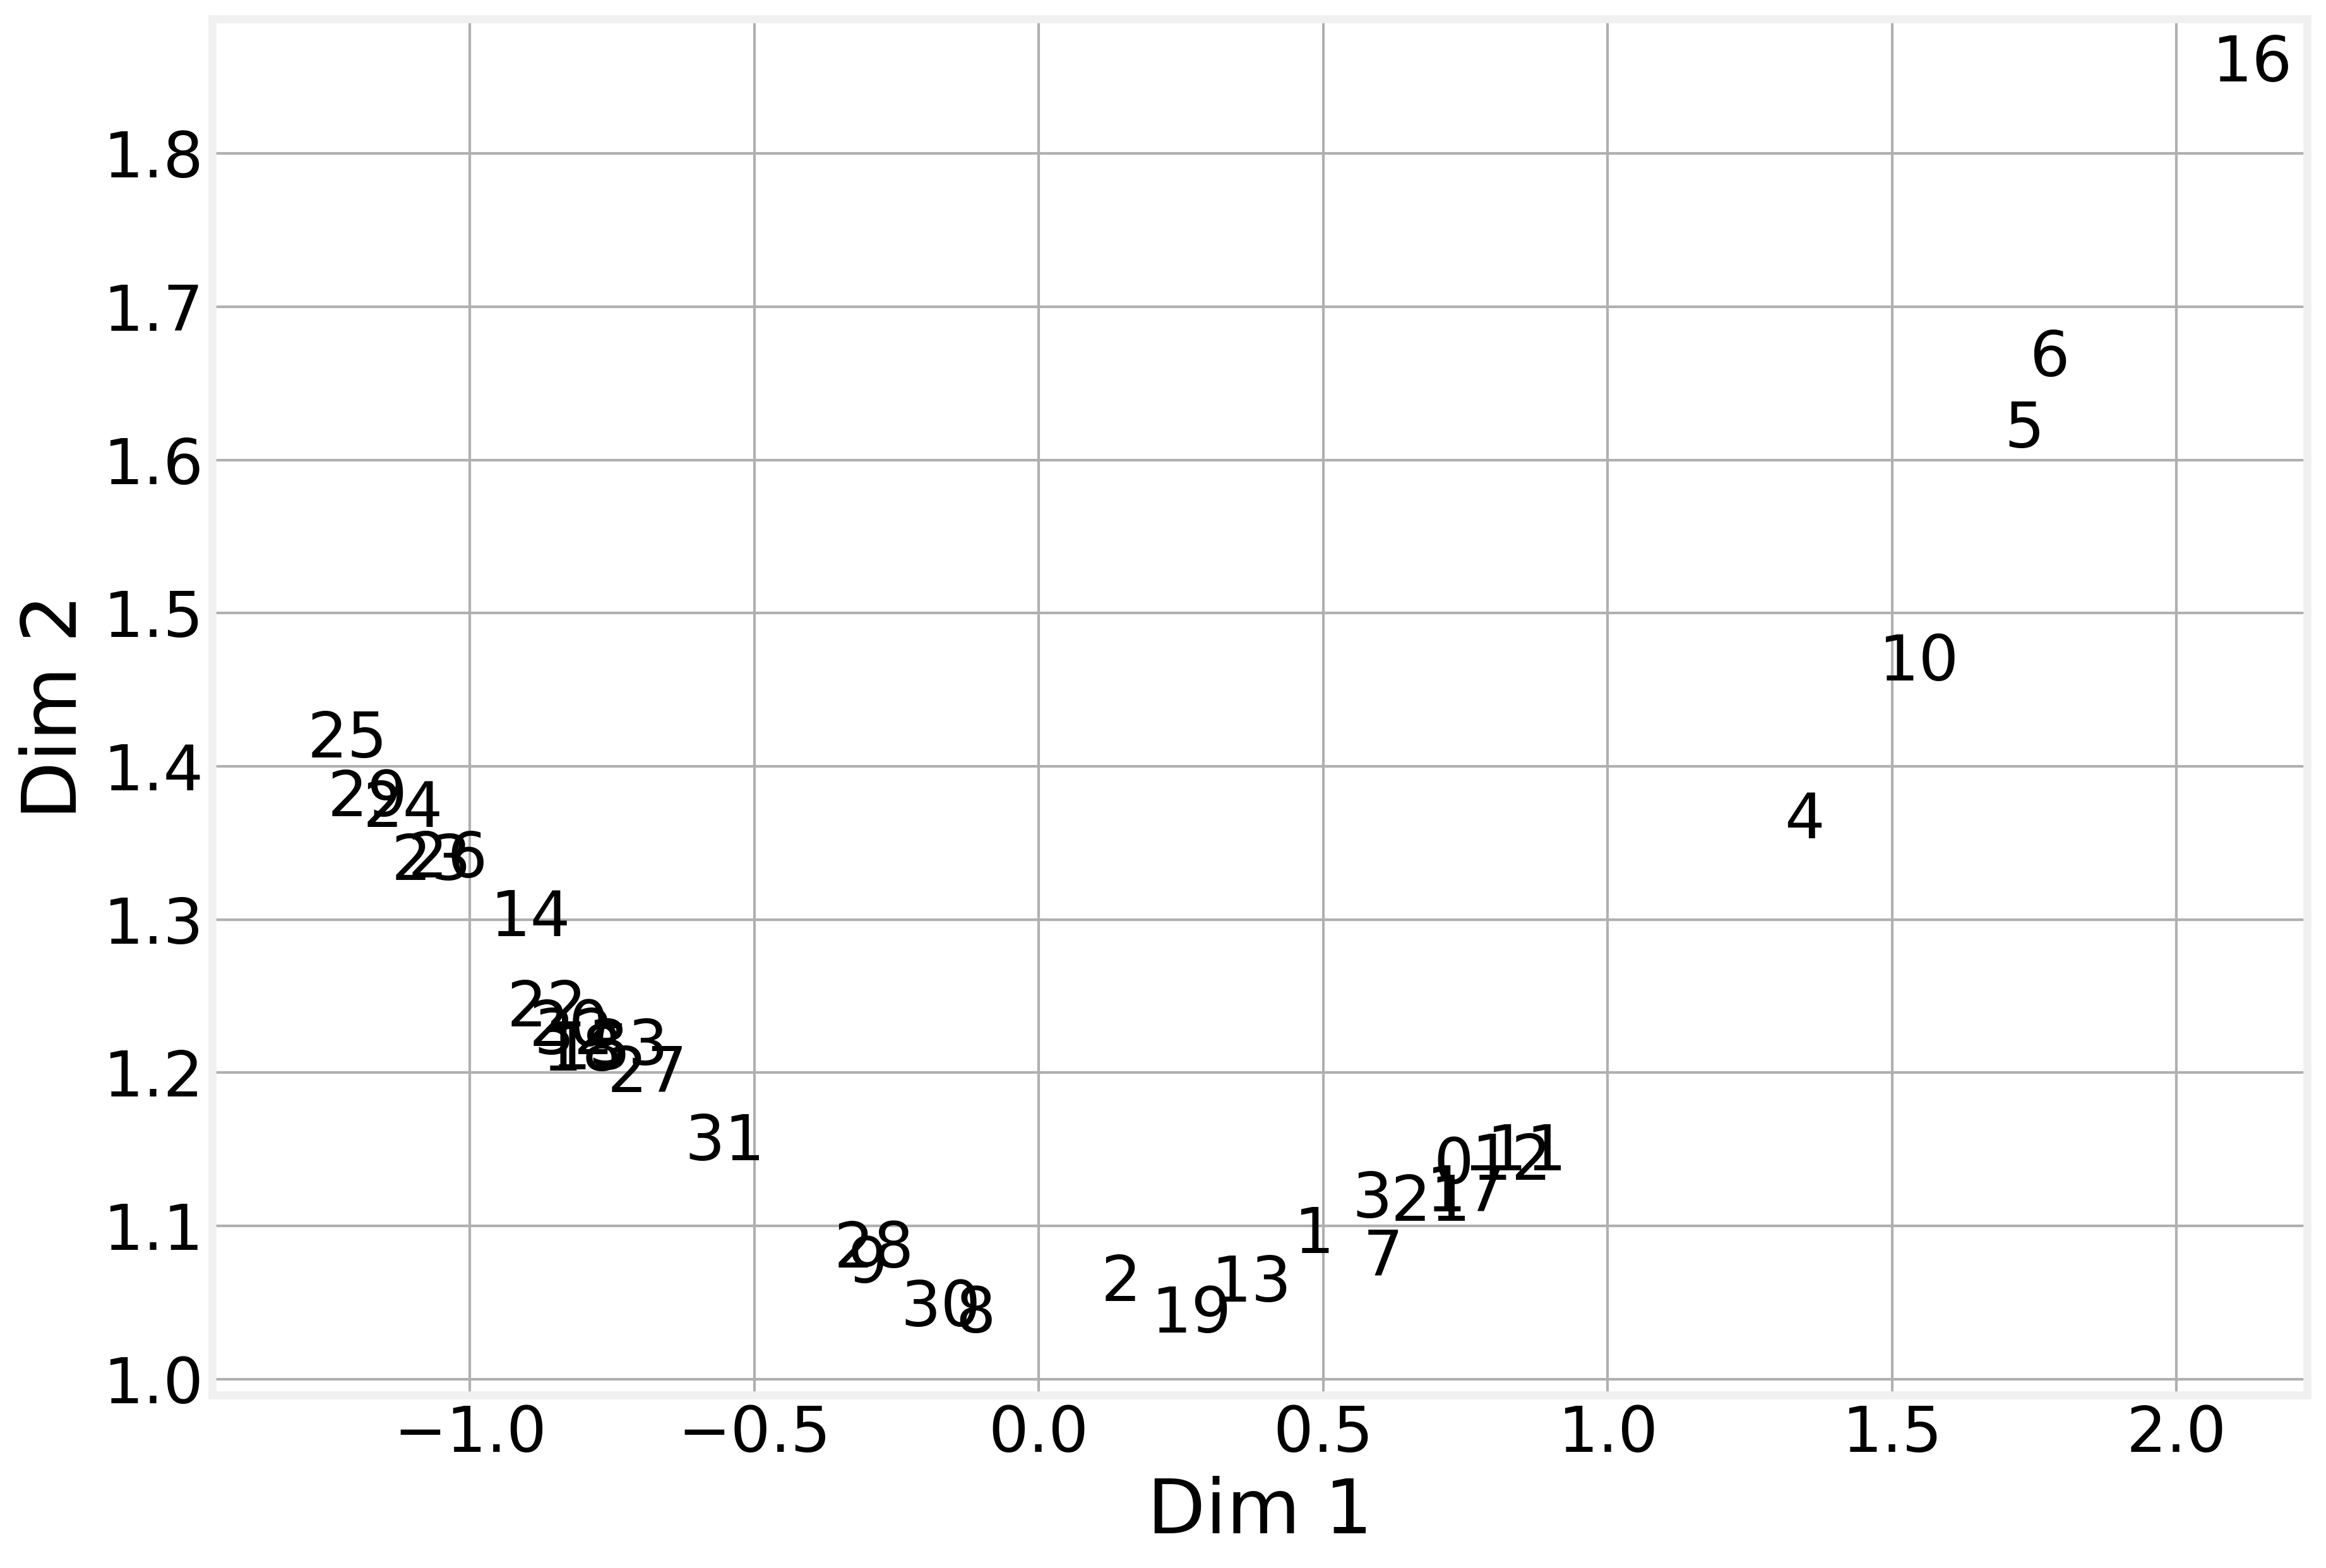

In [21]:
plt.scatter(w2v_emb.vectors.T[0], w2v_emb.vectors.T[1], s=0)
for i in range(len(w2v_emb.index2word)):
    plt.text(w2v_emb.vectors[i, 0], w2v_emb.vectors[i, 1], w2v_emb.index2word[i])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

As you can see, the more extreme nodes in our graph (10, 4, 5, 6, 16) are mostly isolated from the rest of the graph, while the  denser set of nodes is clustered together reflecting the structure of the network. In fact, if we perform a clustering of the nodes using the embeddings from node2vec, we quickly identify three structural communities

In [22]:
km = KMeans(n_clusters=3)
km.fit(w2v_emb.vectors)

KMeans(n_clusters=3)

In [23]:
node_colors = [colors[0] for i in range(len(km.labels_))]

In [24]:
for i, label in enumerate(km.labels_):
    node = int(w2v_emb.index2word[i])
    node_colors[node] = colors[km.labels_[i]]

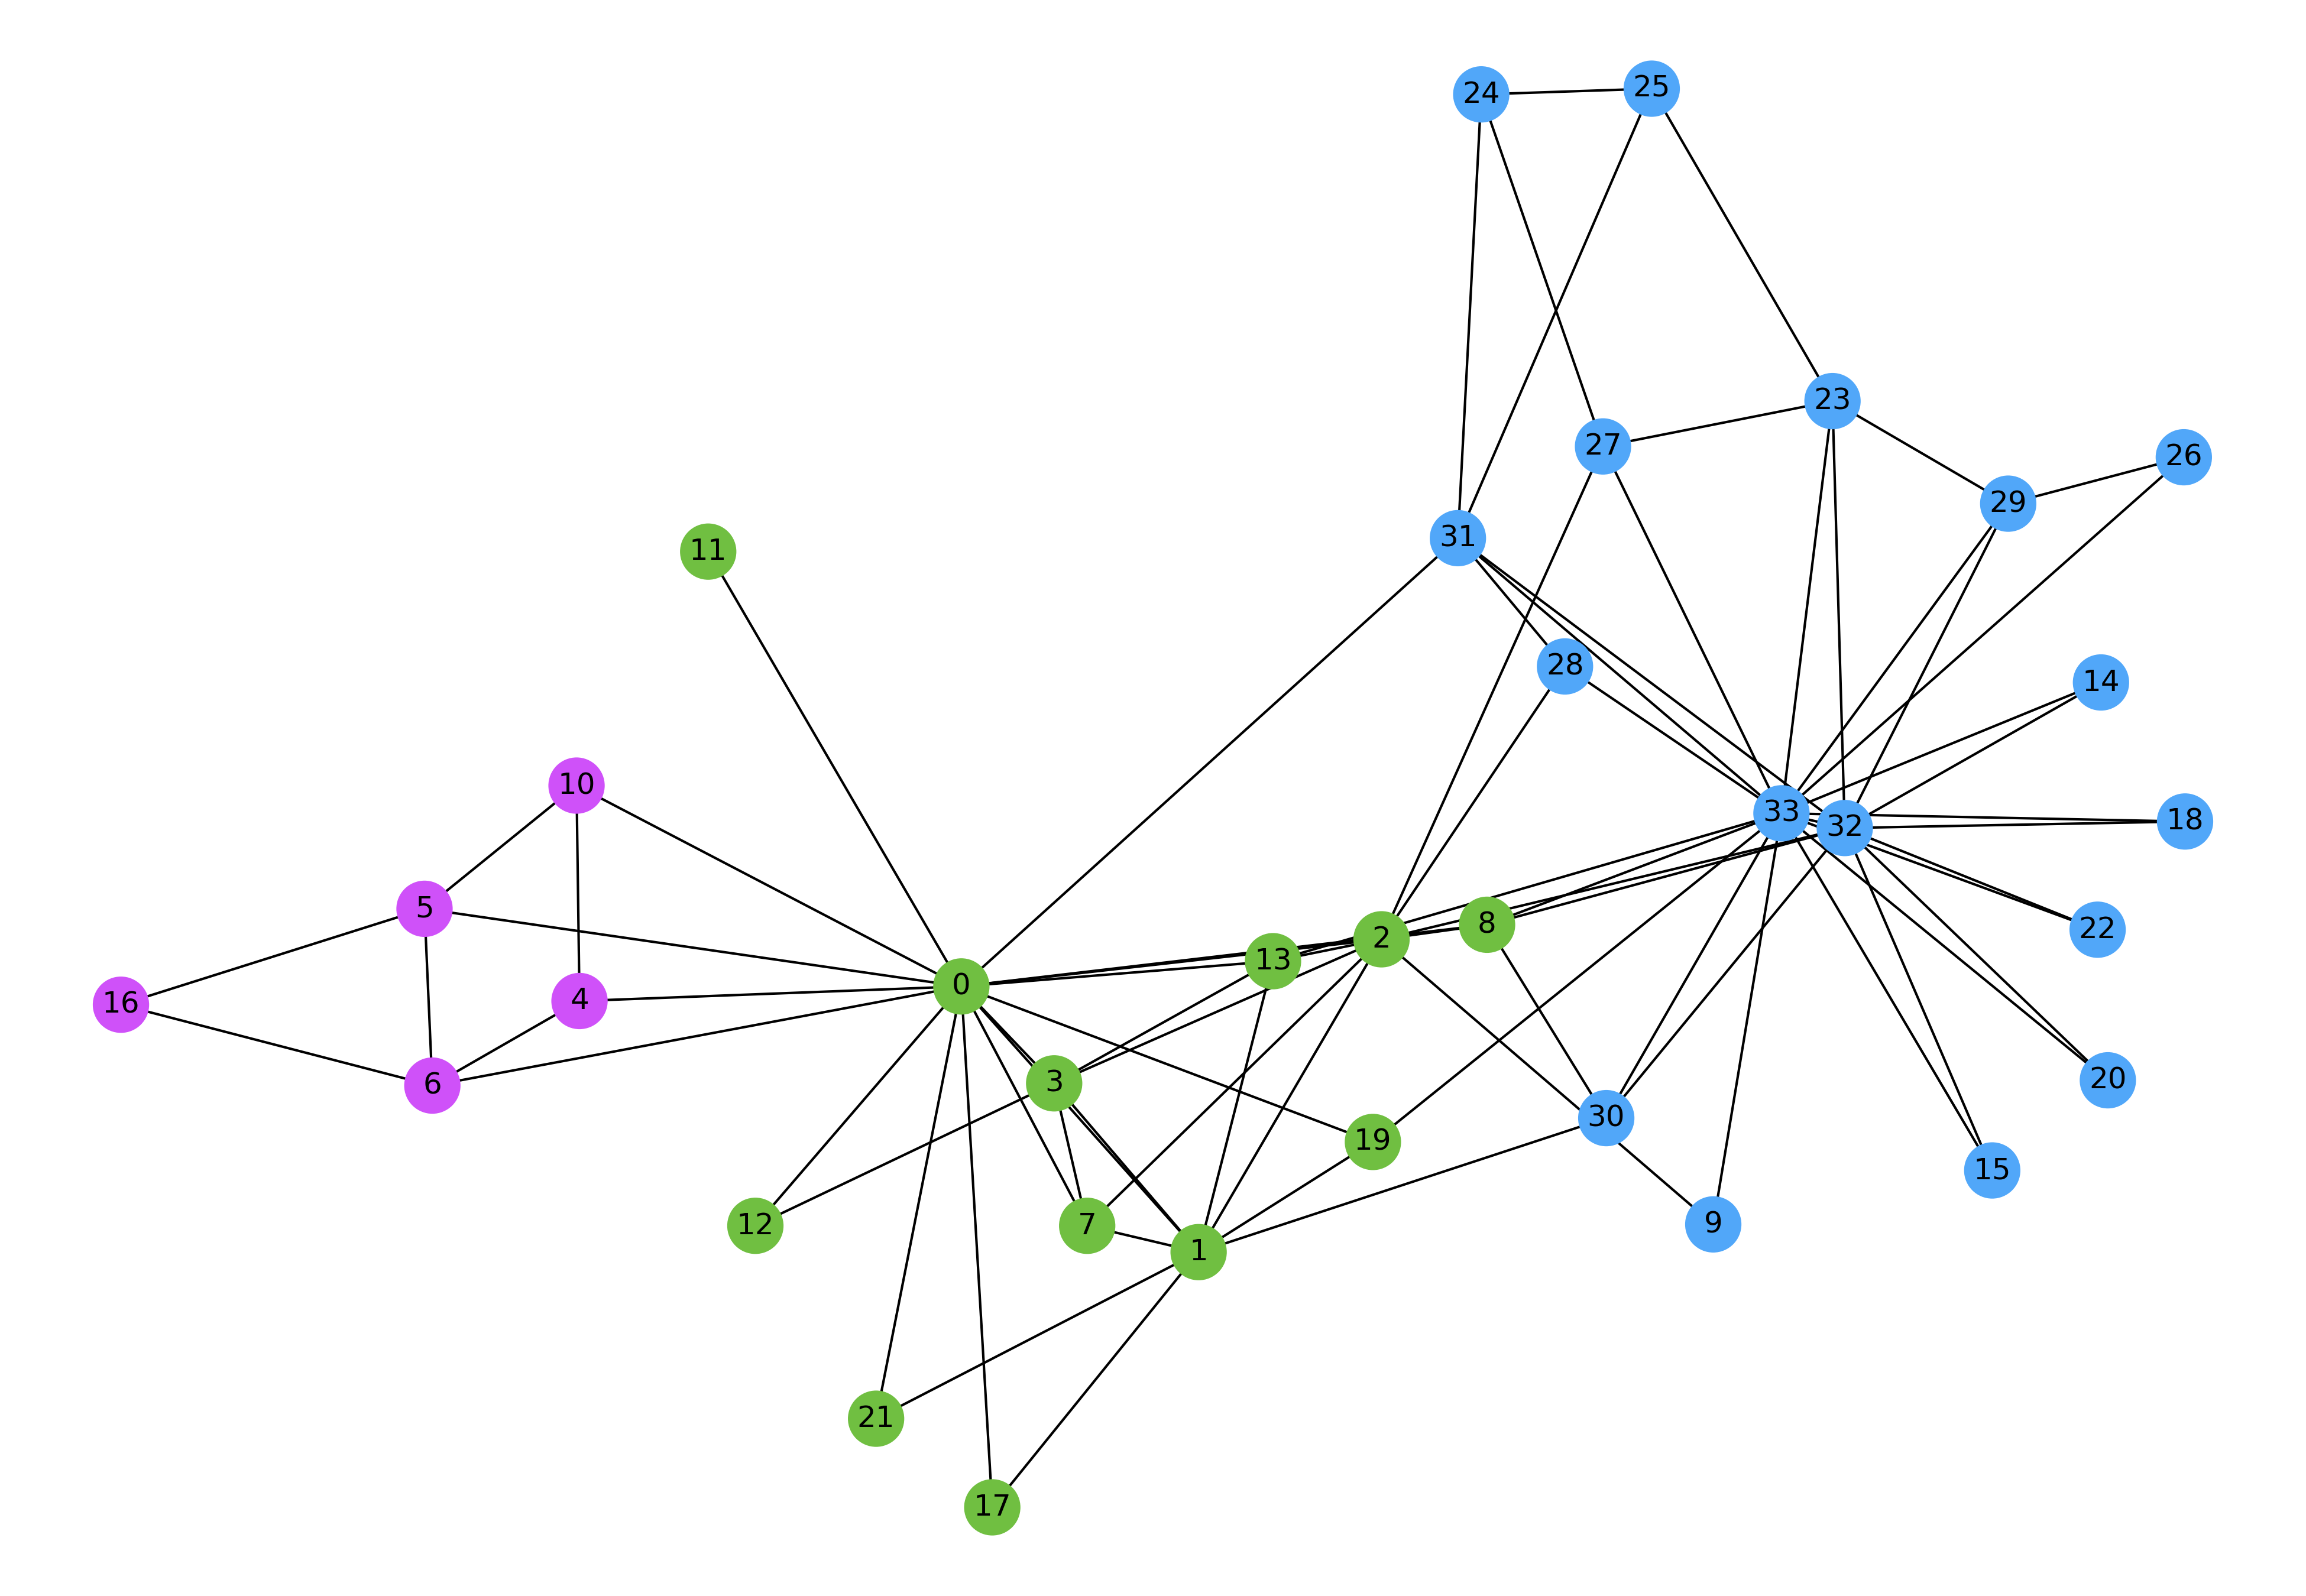

In [25]:
nx.draw(Karate, pos=layout, node_color=node_colors, node_size=500)
nx.draw_networkx_labels(Karate, pos=layout, font_color='k');

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>